## Setup

In [1]:
# Libraries
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from waveome import regularization, utilities, kernels

f64 = gpflow.utilities.to_default_float

## Simulation Example

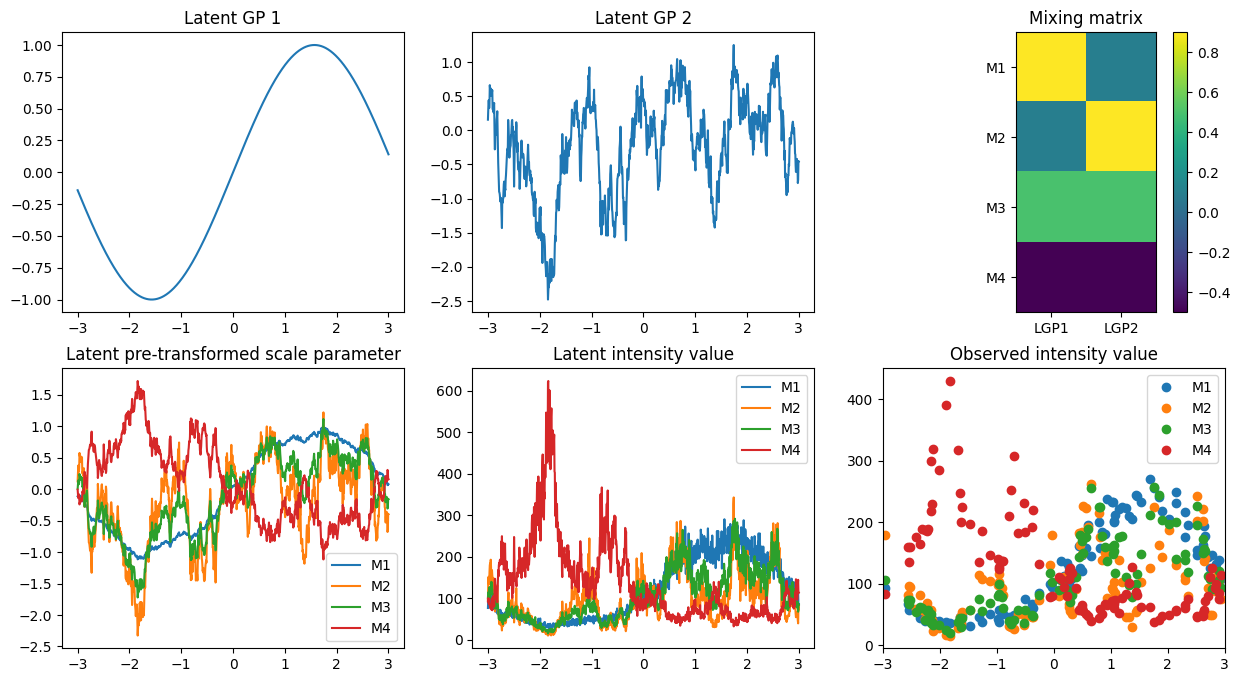

In [2]:
# Set up kernels
k1 = gpflow.kernels.SquaredExponential()
k2 = gpflow.kernels.Matern12(variance=1., lengthscales=0.5)

# Mixing matrix
w_matrix = np.array([[0.9, 0.1],[0.1, 0.9],[.5, .5], [-.5, -.5]])
# w_matrix = np.array([[9, 1],[1, 9],[5, 5], [-5, -5]])


# Input points
x_grid = np.linspace(start=-3, stop=3, num=1000).reshape(-1, 1)
n_obs = 100

# Inference in latent space
np.random.seed(0)
lrv1 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=k1.K(x_grid),
    size=1
).T
# Just make sin function for now
lrv1 = np.sin(x_grid).reshape(-1, 1)

lrv2 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=k2.K(x_grid),
    size=1
).T

# Now mix inputs to make outputs
y_out = (w_matrix @ np.concatenate((lrv1, lrv2), axis=1).T).T

figs, axs = plt.subplots(2, 3, figsize=(15, 8))
axs[0, 0].plot(x_grid, lrv1)
axs[0, 0].set_title("Latent GP 1")
axs[0, 1].plot(x_grid, lrv2)
axs[0, 1].set_title("Latent GP 2")
axs[0, 2].imshow(w_matrix)
axs[0, 2].set_title("Mixing matrix")
axs[0, 2].set_yticks([0, 1, 2, 3])
axs[0, 2].set_yticklabels(["M1", "M2", "M3", "M4"])
axs[0, 2].set_xticks([0, 1])
axs[0, 2].set_xticklabels(["LGP1", "LGP2"])
plt.colorbar(axs[0, 2].imshow(w_matrix), ax=axs[0, 2])

# Now plot the combined GPs
axs[1, 0].plot(x_grid, y_out, label=["M1", "M2", "M3", "M4"])
axs[1, 0].set_title("Latent pre-transformed scale parameter")
axs[1, 0].legend()
obs_out = np.random.gamma(shape=100., scale=np.exp(y_out))
axs[1, 1].plot(x_grid, obs_out, label=["M1", "M2", "M3", "M4"])
axs[1, 1].set_title("Latent intensity value")
axs[1, 1].legend()

# Subset observations
sub_idx = np.random.choice(a=range(len(x_grid)), size=n_obs, replace=False)
axs[1, 2].plot(x_grid[sub_idx], obs_out[sub_idx,:], 'o', label=["M1", "M2", "M3", "M4"])
axs[1, 2].set_xlim((-3, 3))
axs[1, 2].legend()
axs[1, 2].set_title("Observed intensity value")
plt.show()


In [3]:
# Now try to recover the latent kernels
X = x_grid[sub_idx]
Y = obs_out[sub_idx, :]

# Fit multioutput model
m = gpflow.models.SVGP(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    W=np.random.normal(size=(np.shape(Y)[1], 2))
    ),
    likelihood=gpflow.likelihoods.Gamma(),
    inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
        [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(2)]]
    ),
    num_latent_gps=2
)

# gpflow.utilities.set_trainable(m.inducing_variable, False) # When trainable, time ~7m

# Set prior on W matrix
m.kernel.W.prior = tfp.distributions.Exponential(f64(1))

# Freeze variance components
utilities.freeze_variance_parameters(m.kernel)

# Optimize hyperparameters
opt_res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((X, Y)),
    m.trainable_variables
)

print(opt_res)

gpflow.utilities.print_summary(m)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1892.4177793021101
        x: [-5.988e-01  3.467e-01 ...  1.303e+00  1.546e+01]
      nit: 1409
      jac: [-3.263e+00  5.196e-01 ...  5.647e-01 -5.470e-01]
     nfev: 1517
     njev: 1517
 hess_inv: <10511x10511 LbfgsInvHessProduct with dtype=float64>
╒════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════════╤═════════════╤═══════════════╤═════════╤═════════════════════════════════════════════╕
│ name                                               │ class     │ transform        │ prior       │ trainable   │ shape         │ dtype   │ value                                       │
╞═══════════════

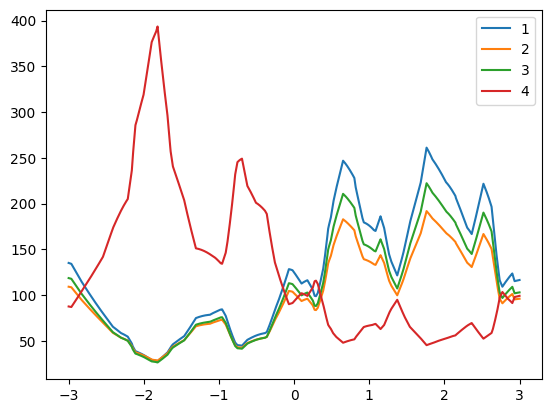

In [4]:
mu_, var_ = m.predict_y(x_grid)
plt.plot(x_grid, mu_, label=[1,2,3,4])
plt.legend()

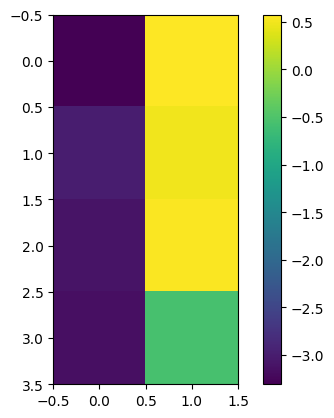

In [5]:
# What does the mixing matrix look like?
plt.imshow(m.kernel.W)
plt.colorbar()
plt.show()

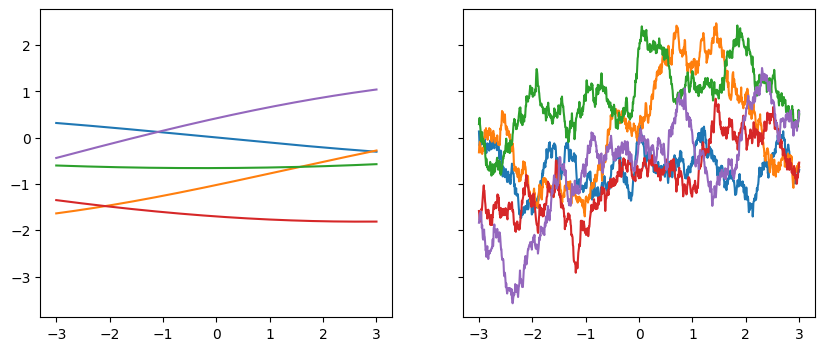

In [6]:
# Inference in latent space
np.random.seed(9102)
lrv1 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=m.kernel.latent_kernels[0].K(x_grid),
    size=5
).T

lrv2 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=m.kernel.latent_kernels[1].K(x_grid),
    size=5
).T

figs, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].plot(x_grid, lrv1)
axs[1].plot(x_grid, lrv2)
plt.show()

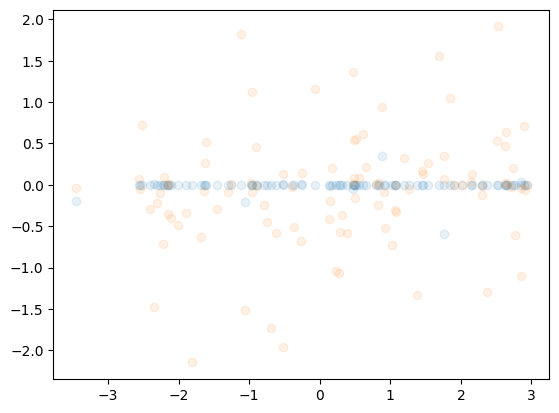

In [7]:
# What do the latent points look like?
plt.plot(m.inducing_variable.inducing_variable_list[0].Z.numpy(), m.q_mu.numpy(), 'o', alpha=0.1)

In [8]:
mu_hat, var_hat = m.predict_f(x_grid)#, full_output_cov=True)

# Get latent mean
l_mu_hat = mu_hat @ tf.transpose(tf.linalg.pinv(m.kernel.W))

# Center means
l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = tf.transpose(tf.linalg.pinv((m.kernel.W)**2) @ tf.transpose(var_hat))

$V(aX+bY+cZ) = a^2V(X)+b^2V(Y)+c^2V(Z)+2abCov(X,Y)+2acCov(X,Z)+2bcCov(Y,Z)$

$V(aX+bY) = [a^2 b^2] [V(X) V(Y)]^T$

In [9]:
# tf.linalg.pinv((m.kernel.W)**2) @ var_hat[0].numpy().reshape(-1, 1)

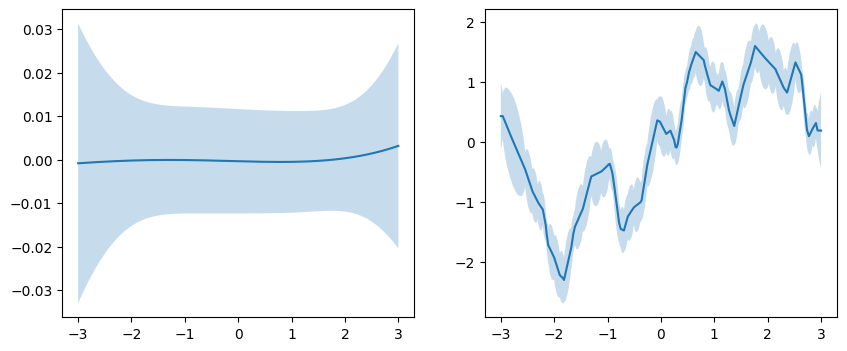

In [10]:
# Now plot latents
figs, axs = plt.subplots(1, 2, figsize=(10,4))
for i in range(2):
    axs[i].fill_between(
        x=x_grid.flatten(), 
        y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
        y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
        alpha=0.25
    )
    axs[i].plot(x_grid, l_mu_hat[:,i])


# Automated kernel selection

In [ ]:
# def freeze_variance_parameters(kernel):
#     if hasattr(kernel, "variance"):
#         gpflow.utilities.set_trainable(kernel.variance, False)
#         return None
#     elif kernel.name in ["sum", "linear_coregionalization"]:
#         for k in kernel.kernels:
#             # print(f"working on kernel {k}")
#             freeze_variance_parameters(k)
#     elif kernel.name == "periodic":
#         freeze_variance_parameters(kernel.base_kernel)

# # freeze_variance_parameters(m_penalized.kernel)

In [ ]:
from waveome import kernels
num_gps = 3
# ll, blam, bgam, mlist 
cv_out = regularization.lam_search(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[
            gpflow.kernels.SquaredExponential(), 
            gpflow.kernels.Matern12(),
            kernels.Lin(active_dims=[0])
            ],
        W=np.ones(shape=(np.shape(Y)[1], num_gps))
    ),
    X=X,
    Y=Y,
    lam_list=[0., 0.5, 1.],
    freeze_inducing=True,
    freeze_variances=True,
    # max_jobs=12,
    random_seed=9102,
    early_stopping=False,
    max_iter=500000
    # verbose=True,
    # return_all=True
)

lambda value = 0.0, gamma value = 0.0


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are use

ll = -32.138997354380976, se = 5.041812332844328
lambda value = 0.5, gamma value = 0.0
ll = -26.079898613110355, se = 0.5581365241347273
lambda value = 1.0, gamma value = 0.0


In [ ]:
gpflow.utilities.parameter_dict(m)[".kernel.kernels[0].variance"].prior

In [ ]:
# for k, v in gpflow.utilities.parameter_dict(m).items():
#     print(f"Key = {k}, value = {v}")

In [ ]:
print(f"Lambda: {cv_out['best_lambda']}")
cv_out["final_model"]

Lambda: 0.5


name,class,transform,prior,trainable,shape,dtype,value
SVPGPR.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,Uniform,True,(),float64,9.15651
SVPGPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[1].lengthscales,Parameter,Softplus,Uniform,True,(),float64,0.17801
SVPGPR.kernel.kernels[2].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.W,Parameter,Identity,,True,"(4, 3)",float64,"[[3.83079, -0.00915, -1.63764..."
SVPGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,640.84553
SVPGPR.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,False,"(100, 1)",float64,[[-1.81682...
SVPGPR.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,False,"(100, 1)",float64,[[0.60961...
SVPGPR.inducing_variable.inducing_variable_list[2].Z,Parameter,Identity,,False,"(100, 1)",float64,[[0.12913...


In [ ]:
# from waveome import kernels
# num_gps = 3

# for l in [0, 0.1, 1, 10, 100, 1000]:
#     m_penalized = regularization.SVPGPR(
#         kernel=gpflow.kernels.LinearCoregionalization(
#             kernels=[
#                 gpflow.kernels.SquaredExponential(), 
#                 gpflow.kernels.Matern12(),
#                 kernels.Lin(active_dims=[0])
#                 ],
#             W=np.random.normal(size=(np.shape(Y)[1], num_gps))
#         ),
#         likelihood=gpflow.likelihoods.Gamma(),
#         inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
#             [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(num_gps)]]
#         ),
#         num_latent_gps=num_gps,
#         X=X[:80, :],
#         Y=Y[:80,:],
#         lam=l #100000000000000000000
#     )

#     # Freeze kernel variance parameters
#     utilities.freeze_variance_parameters(m_penalized.kernel)

#     # Freeze inducing variables
#     gpflow.utilities.set_trainable(m_penalized.inducing_variable.inducing_variables, False)

#     # Set prior on W matrix
#     # m_penalized.kernel.W.prior = tfp.distributions.Exponential(f64(1))

#     # Optimize hyperparameters
#     opt_res = gpflow.optimizers.Scipy().minimize(
#         m_penalized.training_loss_closure((X[:80,:], Y[:80,:])),
#         m_penalized.trainable_variables,
#         options={"maxiter": 20000}
#     )

#     print(f"Holdout LogLik: {tf.reduce_sum(m_penalized.predict_log_density((X[80:,:],Y[80:,:])))}")
#     print(l)
#     print(np.abs(m_penalized.kernel.W.numpy()).sum())
#     print(m_penalized.kernel.W)

# # print(opt_res)

# # gpflow.utilities.print_summary(m_penalized)

In [ ]:
# m_penalized = regularization.SVPGPR(
#     kernel=gpflow.kernels.LinearCoregionalization(
#         kernels=[
#             gpflow.kernels.SquaredExponential(), 
#             gpflow.kernels.Matern12(),
#             kernels.Lin(active_dims=[0])
#             ],
#     W=np.random.normal(size=(np.shape(Y)[1], num_gps))
#     ),
#     likelihood=gpflow.likelihoods.Gamma(),
#     inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
#         [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(num_gps)]]
#     ),
#     num_latent_gps=num_gps,
#     X=X,
#     Y=Y,
#     lam=blam
# )

# # Freeze kernel variance parameters
# utilities.freeze_variance_parameters(m_penalized.kernel)

# # Freeze inducing variables
# gpflow.utilities.set_trainable(m_penalized.inducing_variable.inducing_variables, False)

# # Set prior on W matrix
# # m_penalized.kernel.W.prior = tfp.distributions.Exponential(f64(1))

# # Optimize hyperparameters
# opt_res = gpflow.optimizers.Scipy().minimize(
#     m_penalized.training_loss_closure((X, Y)),
#     m_penalized.trainable_variables,
#     options={"maxiter": 20000}
# )

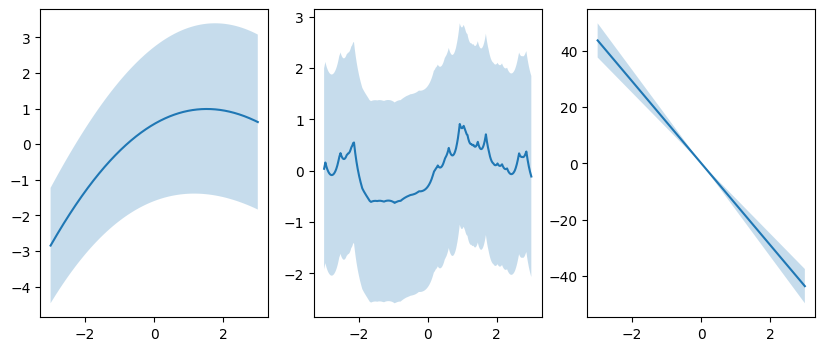

In [ ]:
mu_hat, var_hat = cv_out["final_model"].predict_f(x_grid)#, full_output_cov=True)

# Get latent mean
l_mu_hat = mu_hat @ tf.transpose(tf.linalg.pinv(cv_out["final_model"].kernel.W))

# Center means
l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = tf.transpose(tf.linalg.pinv((cv_out["final_model"].kernel.W)**2) @ tf.transpose(var_hat))

# Now plot latents
figs, axs = plt.subplots(1, num_gps, figsize=(10,4))
for i in range(num_gps):
    axs[i].fill_between(
        x=x_grid.flatten(), 
        y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
        y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
        alpha=0.25
    )
    axs[i].plot(x_grid, l_mu_hat[:,i])


## Now add multiple units

In [18]:
k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

x_grid = np.linspace(start=-3, stop=3, num=500).reshape(-1, 1)
w_matrix = np.array([[0.9, 0.1],[0.1, 0.9],[.5, .5], [-.5, -.5]])
ids = np.arange(start=1, stop=6)
id_grid = np.repeat(ids, len(x_grid)).reshape(-1, 1)
multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
multi_x_grid = np.hstack((id_grid, multi_x_grid))

In [19]:
np.random.seed(9102)

# Seasonality component shared across individuals
# lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
lrv1_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k1_ind(multi_x_grid),
    size=1
).T

# Individual component
lrv2_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k2_ind(multi_x_grid),
    size=1
).T

multi_y = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T
multi_y = np.random.gamma(shape=100., scale=np.exp(multi_y))

y_: 0, row_c: 0
y_: 1, row_c: 0
y_: 2, row_c: 1
y_: 3, row_c: 1


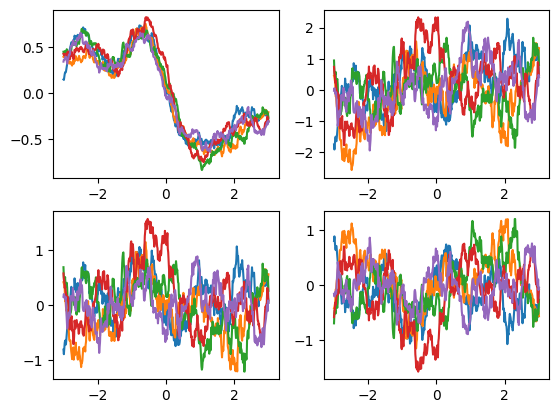

In [20]:
figs, axs = plt.subplots(2, 2)
row_c = 0
for y_ in range(multi_y.shape[1]):
    print(f"y_: {y_}, row_c: {row_c}")
    for i in np.unique(id_grid):
        axs[row_c % 2, y_ % 2].plot(multi_x_grid[multi_x_grid[:,0] == i, 1], multi_y[multi_x_grid[:, 0] == i, y_])
    if y_ == 1:
        row_c += 1

In [21]:
# Now make the observed dataset
k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

np.random.seed(9102)
ids = np.arange(start=1, stop=101)
# Get midpoint for each individual
id_mid = np.random.uniform(low=-3, high=3, size=len(ids))
# Now get points around each individuals midpoint
num_obs_per_id = 10
x_grid = np.concatenate([np.random.normal(loc=x, scale=1., size=num_obs_per_id) for x in id_mid]).reshape(-1, 1)
id_grid = np.repeat(ids, num_obs_per_id).reshape(-1, 1)
# multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
multi_x_grid = np.hstack((id_grid, x_grid))

# Seasonality component shared across individuals
# lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
lrv1_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k1_ind(multi_x_grid),
    size=1
).T

# Individual component
lrv2_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k2_ind(multi_x_grid),
    size=1
).T

multi_y = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T

# Pass through likelihood now
multi_y = np.random.gamma(shape=100., scale=np.exp(multi_y))
multi_y.shape

(1000, 4)

In [22]:
num_gps = 7
# ll, blam, bgam, mlist 
cv_out_multi = regularization.lam_search(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[
            kernels.Categorical(active_dims=[0]),
            gpflow.kernels.SquaredExponential(active_dims=[1]), 
            gpflow.kernels.Matern12(active_dims=[1]),
            kernels.Lin(active_dims=[1]),
            kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
            kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
            kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
            ],
        W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
    ),
    X=multi_x_grid,
    Y=multi_y,
    lam_list=np.arange(start=0, stop=1.1, step=0.05), #[0., 0.25, 0.5, 0.75, 1.],
    # freeze_inducing=True,
    num_inducing_points=100,
    k_fold=5,
    freeze_variances=True,
    random_seed=9102,
    # early_stopping=False,
    # verbose=True,
    unit_col=0,
    likelihood="gamma"
)

lambda value = 0.0, gamma value = 0.0


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are use

ll = -22.433573254083996, se = 0.20856853554760602
lambda value = 0.05, gamma value = 0.0
lambda value = 0.1, gamma value = 0.0
lambda value = 0.15000000000000002, gamma value = 0.0
lambda value = 0.2, gamma value = 0.0
lambda value = 0.25, gamma value = 0.0
Stopping early!
-22.87524044063851
-22.842367583757305
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


In [9]:
cv_out_multi

{'cv_log_lik': {0.0: {0.0: [-22.629636739622487,
    -21.86390676505009,
    -21.654444233221753,
    -21.752848726390766,
    -21.67944774569751]},
  0.05: {0.0: [-22.146614850009684,
    -21.937151805393977,
    -21.804851495259914,
    -21.900623660273595,
    -21.659682326640464]},
  0.1: {0.0: [-22.158303243170717,
    -21.92545311252327,
    -21.81807396608864,
    -21.887036676654617,
    -21.650809840875258]},
  0.15000000000000002: {0.0: [-22.243805305387795,
    -21.953066672631557,
    -21.818834489130122,
    -22.520075657651333,
    -21.72702501467555]},
  0.2: {0.0: []},
  0.25: {0.0: []},
  0.30000000000000004: {0.0: []},
  0.35000000000000003: {0.0: []},
  0.4: {0.0: []},
  0.45: {0.0: []},
  0.5: {0.0: []},
  0.55: {0.0: []},
  0.6000000000000001: {0.0: []},
  0.65: {0.0: []},
  0.7000000000000001: {0.0: []},
  0.75: {0.0: []},
  0.8: {0.0: []},
  0.8500000000000001: {0.0: []},
  0.9: {0.0: []},
  0.9500000000000001: {0.0: []},
  1.0: {0.0: []},
  1.05: {0.0: []}},
 'b

In [ ]:
# num_gps = 6
# m_foo, bic_foo = regularization.kernel_test_reg(
#     k=gpflow.kernels.LinearCoregionalization(
#         kernels=[
#             # kernels.Categorical(active_dims=[0]),
#             gpflow.kernels.SquaredExponential(active_dims=[1]), 
#             gpflow.kernels.Matern12(active_dims=[1]),
#             kernels.Lin(active_dims=[1]),
#             kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
#             kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
#             kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
#             ],
#         W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
#     ),
#     X=multi_x_grid,
#     Y=multi_y,
#     lam_list=[0., 1.],#, 0.25, 0.5, 0.75, 1.],
#     freeze_inducing=True,
#     num_inducing_points=200,
#     freeze_variances=True,
#     random_seed=9102,
#     early_stopping=False,
#     verbose=True,
#     lasso=True,
#     random_init=True
# ) # 13m 3.3s 10,000 max iter, # 9m 15s 5,000 max iter, # 4m 2.1s if freeze_inducing is True

In [10]:
cv_out_multi["final_model"].kernel.W

<Parameter: name=identity, dtype=float64, shape=[4, 7], fn="identity", numpy=
array([[-7.08771930e-07, -2.14751199e-01,  4.08714061e-01,
        -3.79708051e-08,  2.98666635e-07,  7.84081163e-08,
        -3.09133021e-08],
       [ 5.80865957e-07,  3.05423147e-02,  4.60750647e-01,
        -5.56152297e-08, -2.35368569e-07,  9.62289947e-08,
        -1.18186188e-07],
       [ 8.00373388e-07, -9.32401594e-02,  4.25721880e-01,
        -2.43347579e-07, -5.55602921e-07, -3.34047081e-07,
         3.89345588e-08],
       [ 1.43996782e-07,  1.90087663e-01,  4.22913884e-01,
        -4.16097229e-02, -6.88590039e-07,  3.09142524e-07,
         9.93118007e-08]])>

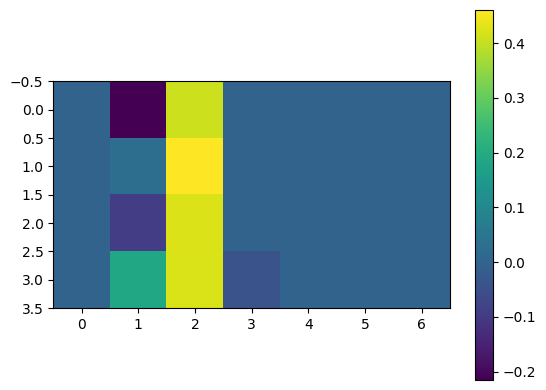

In [11]:
plt.imshow(cv_out_multi["final_model"].kernel.W)
plt.colorbar()
plt.show()

In [15]:
np.std(multi_y, axis=0)

array([ 77.30378009, 142.59784594,  73.55113029,  77.55414606])

In [14]:
multi_y.var(axis=0)

array([ 5975.87441639, 20334.14566707,  5409.76876655,  6014.64557151])

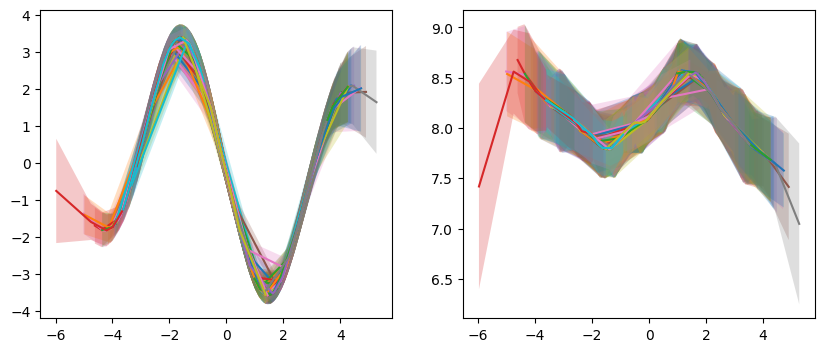

In [12]:
multi_x_grid_sorted = multi_x_grid[np.argsort(multi_x_grid[:, 1])]

mu_hat, var_hat = cv_out_multi["final_model"].predict_f(multi_x_grid_sorted)#, full_output_cov=True)

# "On" processes
W_ = cv_out_multi["final_model"].kernel.W.numpy()
keep_gps = np.abs(W_).max(axis=0) > 0.1

# Get latent mean
l_mu_hat = mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_[:, keep_gps]))

# Center means
# l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = np.transpose(np.linalg.pinv((W_[:, keep_gps])**2) @ np.transpose(var_hat))

# Now plot latents
figs, axs = plt.subplots(1, sum(keep_gps), figsize=(10,4))
for i in range(sum(keep_gps)):
    for idx in np.unique(multi_x_grid_sorted[:, 0]):
        axs[i].fill_between(
            x=multi_x_grid_sorted[multi_x_grid_sorted[:, 0] == idx, 1].flatten(), 
            y1=l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i] - 1.96*np.sqrt(l_var_hat[multi_x_grid_sorted[:, 0] == idx, i]),
            y2=l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i] + 1.96*np.sqrt(l_var_hat[multi_x_grid_sorted[:, 0] == idx, i]),
            alpha=0.25
        )
        axs[i].plot(multi_x_grid_sorted[multi_x_grid_sorted[:, 0] == idx, 1], l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i])


## Full simulation set up

In [ ]:
def generate_sim_data(num_ids, num_obs_per_id, random_seed):
    # Now make the observed dataset
    k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
    k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

    np.random.seed(random_seed)
    ids = np.arange(start=0, stop=num_ids)
    # Get midpoint for each individual
    id_mid = np.random.uniform(low=-3, high=3, size=len(ids))
    # Now get points around each individuals midpoint
    # num_obs_per_id = 
    x_grid = np.concatenate([np.random.normal(loc=x, scale=1., size=num_obs_per_id) for x in id_mid]).reshape(-1, 1)
    id_grid = np.repeat(ids, num_obs_per_id).reshape(-1, 1)
    # multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
    multi_x_grid = np.hstack((id_grid, x_grid))

    # Seasonality component shared across individuals
    # lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
    lrv1_multi = np.random.multivariate_normal(
        mean=np.zeros_like(id_grid.flatten()),
        cov=k1_ind(multi_x_grid),
        size=1
    ).T

    # Individual component
    lrv2_multi = np.random.multivariate_normal(
        mean=np.zeros_like(id_grid.flatten()),
        cov=k2_ind(multi_x_grid),
        size=1
    ).T

    multi_y = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T

    # Pass through likelihood now
    multi_y = np.random.gamma(shape=100., scale=np.exp(multi_y))
    return multi_x_grid, multi_y

def build_model():
    num_gps = 7
    # ll, blam, bgam, mlist 
    cv_out_multi = regularization.lam_search(
        kernel=gpflow.kernels.LinearCoregionalization(
            kernels=[
                kernels.Categorical(active_dims=[0]),
                gpflow.kernels.SquaredExponential(active_dims=[1]), 
                gpflow.kernels.Matern12(active_dims=[1]),
                kernels.Lin(active_dims=[1]),
                kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
                kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
                kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
                ],
            W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
        ),
        X=multi_x_grid,
        Y=multi_y,
        lam_list=np.arange(start=0, stop=1.1, step=0.05), #[0., 0.25, 0.5, 0.75, 1.],
        # freeze_inducing=True,
        num_inducing_points=100,
        k_fold=5,
        freeze_variances=True,
        random_seed=9102,
        # early_stopping=False,
        # verbose=True,
        unit_col=0,
        likelihood="gamma"
    )

    return cv_out_multi

def evaluate_fit():
    return None